In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from FindCorrespondPts import findCorrespondPts
from segmentation import robotSegmentv2, ransacCurveFit
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook

In [2]:
def imshow(img, size=None):
    if size == None:
        plt.figure(figsize=(14,18))
    else:
        plt.figure(figsize=size)
    plt.imshow(img)
    plt.show()

def imshow2(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
# Loading parameters
imgl_pts = np.load('./calibration/blob_loc_left.npy')
imgr_pts = np.load('./calibration/blob_loc_right.npy')
coeff_left = np.load('./calibration/calibration_coeff_left.npy').item()
kl = coeff_left['intr_mat']

coeff_right = np.load('./calibration/calibration_coeff_right.npy').item()
kr = coeff_right['intr_mat']

trian_param = np.load('./calibration/triangulate_coeff.npy').item()

F = trian_param['F']
# 2 possible solutions for Rotation and Translation
R1 = trian_param['R1']
R2 = trian_param['R2']
T1 = trian_param['T1']
T2 = trian_param['T2']

# 4 Possible projection matrix for right camera
PR1 = np.hstack((R1, T1))
PR2 = np.hstack((R1, T2))
PR3 = np.hstack((R2, T1))
PR4 = np.hstack((R2, T2))

# Initialize Left projection matrix
PL = trian_param['PL']

PR = PR4

# Calculate template points
PR_cal = np.matmul(kr, PR)
PL_cal = np.matmul(kl, PL)

In [4]:
# Template points as reference
temp = cv2.triangulatePoints(PL_cal, PR_cal, imgl_pts, imgr_pts).T
temp3D = cv2.convertPointsFromHomogeneous(temp).T[:,0]

pts3D_collect = []
# Robot images
idx_all = list(range(0,50))
#idx = 300
for idx in tqdm_notebook(idx_all):
    imgL = cv2.imread('../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
    imgR = cv2.imread('../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

    bg1 = cv2.imread('./segmentation/bg_res/bg_1.png')
    bg2 = cv2.imread('./segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

    segL = robotSegmentv2(imgL, bg2)
    segR = robotSegmentv2(imgR, bg1)

    fitL = ransacCurveFit(segL)
    fitR = ransacCurveFit(segR)


    ptsL, ptsR = findCorrespondPts(fitL, fitR, F, sampleSize = 50, thresh = 0.5)
    pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL, ptsR).T
    pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]
    pts3D_collect.append(pts3D)

<IPython.core.display.Javascript object>


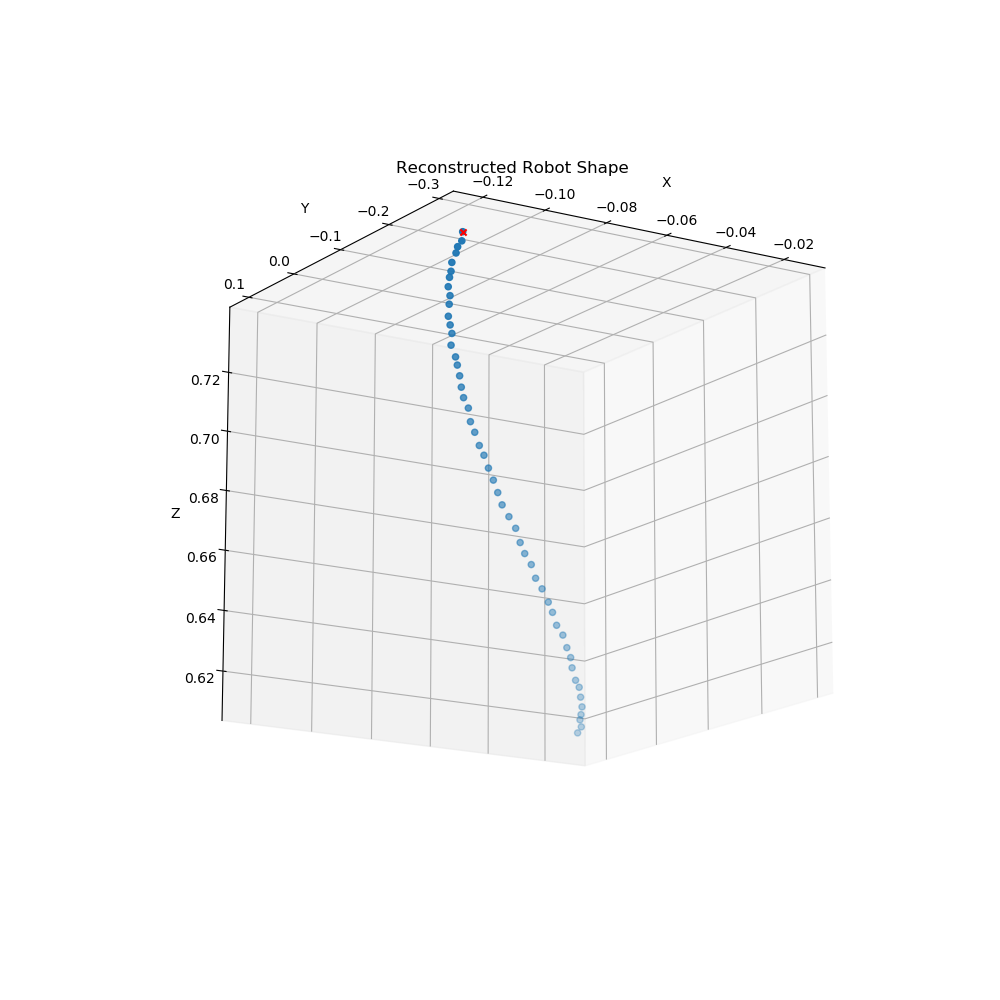

In [5]:
%matplotlib notebook
pts3D = pts3D_collect[6]
# Plot
Xs = pts3D[0]
Ys = pts3D[1]
Zs = pts3D[2]

Xs_tp = temp3D[0]
Ys_tp = temp3D[1]
Zs_tp = temp3D[2]

#Ys = res3D[0]
#Zs = res3D[1]
#Xs = res3D[2]

#%matplotlib inline
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xs, Ys, Zs)
#ax.scatter(Xs_tp, Ys_tp, Zs_tp)

idx = 0
ax.scatter(Xs[idx], Ys[idx], Zs[idx], c='red', marker='x')
#ax.scatter(Xs_tp[idx], Ys_tp[idx], Zs_tp[idx], c='blue', marker='x')

#ax.scatter(loc1[0], loc1[1], loc1[2],c='red', marker='x')
#ax.scatter(loc2[0], loc2[1], loc2[2],c='blue', marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Reconstructed Robot Shape')
plt.show()

## Meeting 

1. Smooth the data. Get equations in 2D. No need to plot a binary image.
2. Pick 100 image pair for evaluation. Calcualte segment-wise length. 

## Smooth Shape Version

In [12]:
from newPipeline import findCorrespondPts_v2, ransacCurveFit_v2

idx = 6

imgL = cv2.imread('../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
imgR = cv2.imread('../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

bg1 = cv2.imread('./segmentation/bg_res/bg_1.png')
bg2 = cv2.imread('./segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

segL = robotSegmentv2(imgL, bg2)
segR = robotSegmentv2(imgR, bg1)

ptsR = ransacCurveFit_v2(segR, degree = 7, trials = 100, sampleNum = 100000)
ptsL = ransacCurveFit_v2(segL, degree = 7, trials = 100, sampleNum = 50)

ptsL_cor, ptsR_cor = findCorrespondPts_v2(ptsL, ptsR, F, thresh = 0.01)

pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL_cor, ptsR_cor).T
pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]

<IPython.core.display.Javascript object>


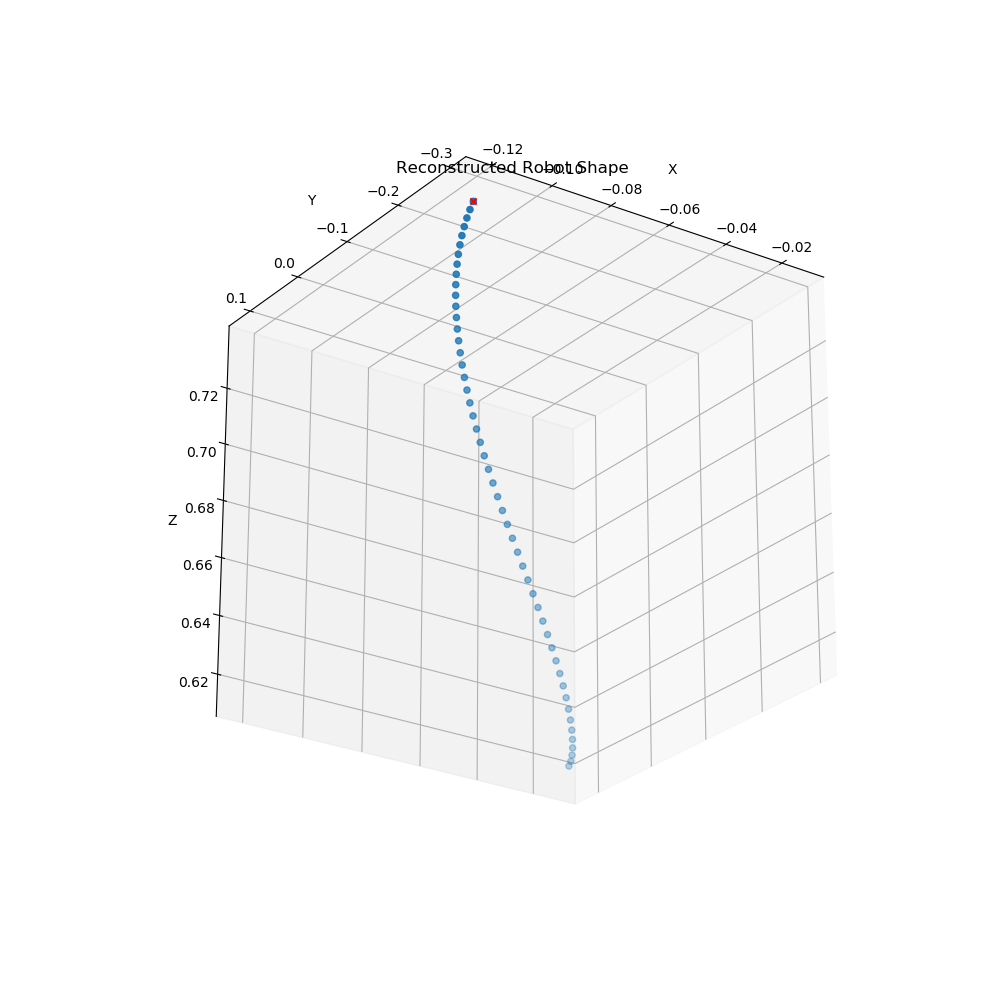

In [13]:
%matplotlib notebook
# Plot
Xs = pts3D[0]
Ys = pts3D[1]
Zs = pts3D[2]


#Ys = res3D[0]
#Zs = res3D[1]
#Xs = res3D[2]

#%matplotlib inline
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xs, Ys, Zs, s = 20)
#ax.scatter(Xs_tp, Ys_tp, Zs_tp)

idx = 0
ax.scatter(Xs[idx], Ys[idx], Zs[idx], c='red', marker='x')
#ax.scatter(Xs_tp[idx], Ys_tp[idx], Zs_tp[idx], c='blue', marker='x')

#ax.scatter(loc1[0], loc1[1], loc1[2],c='red', marker='x')
#ax.scatter(loc2[0], loc2[1], loc2[2],c='blue', marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Reconstructed Robot Shape')
plt.show()

## Evaluation

In [17]:
# Load joint data points 
pt_seg_left = np.load('./segmentation/evaluation_pt_left.npy').item()
pt_seg_right = np.load('./segmentation/evaluation_pt_right_comp.npy').item()

In [18]:
eval_idx = list(pt_seg_left.keys()) + list((pt_seg_right.keys()))

In [19]:
# Obtain results for evaluation
pts3D_eval = {}
for idx in tqdm_notebook(eval_idx):
    imgL = cv2.imread('../data/CTR_Robot/Camera2/cam2_' + str(idx) + '.png')
    imgR = cv2.imread('../data/CTR_Robot/Camera1/cam1_' + str(idx) + '.png')

    bg1 = cv2.imread('./segmentation/bg_res/bg_1.png')
    bg2 = cv2.imread('./segmentation/bg_res/bg_2_' + str(idx//50) + '.png')

    segL = robotSegmentv2(imgL, bg2)
    segR = robotSegmentv2(imgR, bg1)

    ptsR = ransacCurveFit_v2(segR, degree = 7, trials = 100, sampleNum = 100000)
    ptsL = ransacCurveFit_v2(segL, degree = 7, trials = 100, sampleNum = 100)

    ptsL_cor, ptsR_cor = findCorrespondPts_v2(ptsL, ptsR, F, thresh = 0.01)

    pts = cv2.triangulatePoints(PL_cal, PR_cal, ptsL_cor, ptsR_cor).T
    pts3D = cv2.convertPointsFromHomogeneous(pts).T[:,0]
    pts3D_eval[idx] = [ptsL_cor, ptsR_cor, pts3D]

In [20]:
pt_joint_eval = {}
for idx in tqdm_notebook(eval_idx):
    if idx in pt_seg_left:
        pt_seg = pt_seg_left
        pts_cor = pts3D_eval[idx][0]
    elif idx in pt_seg_right:
        pt_seg = pt_seg_right
        pts_cor = pts3D_eval[idx][1]
    
    # extract label joint points 
    pt1 = pt_seg[idx][0]
    pt2 = pt_seg[idx][1]
    
    # calculate most close points as joint point
    mat1 = pts_cor[0] - pt1
    dist1 = np.sqrt(np.diag(np.matmul(mat1, mat1.T)))
    jointPt1 = np.argmin(dist1)
    
    mat2 = pts_cor[0] - pt2
    dist2 = np.sqrt(np.diag(np.matmul(mat2, mat2.T)))
    jointPt2 = np.argmin(dist2)
    
    # save 2 joints for each case
    pt_joint_eval[idx] = (jointPt1, jointPt2)
    

In [25]:
pt_joint_eval

{302: (65, 84),
 303: (64, 72),
 304: (73, 85),
 305: (51, 71),
 307: (56, 82),
 309: (74, 91),
 311: (73, 76),
 312: (71, 89),
 315: (55, 71),
 317: (70, 75),
 318: (57, 89),
 320: (48, 73),
 321: (36, 69),
 322: (53, 88),
 325: (37, 71),
 326: (38, 73),
 327: (37, 69),
 328: (42, 68),
 329: (62, 66),
 330: (31, 61),
 332: (43, 73),
 334: (80, 83),
 336: (79, 89),
 337: (53, 81),
 338: (63, 79),
 341: (55, 85),
 343: (69, 75),
 346: (72, 80),
 347: (47, 70),
 350: (73, 96),
 356: (72, 84),
 358: (65, 87),
 392: (58, 85),
 393: (67, 90),
 395: (67, 79),
 396: (71, 99),
 397: (76, 84),
 398: (67, 71),
 399: (56, 84),
 400: (71, 86),
 404: (57, 78),
 405: (57, 83),
 409: (56, 64),
 410: (51, 79),
 414: (55, 65),
 415: (52, 74),
 417: (62, 81),
 420: (82, 86),
 421: (69, 91),
 422: (56, 87),
 423: (74, 91),
 429: (53, 85),
 432: (60, 64),
 433: (45, 76),
 436: (63, 80),
 438: (65, 86),
 439: (67, 87),
 441: (65, 83),
 443: (57, 71),
 444: (70, 97),
 445: (76, 80),
 447: (41, 71),
 451: (5

<IPython.core.display.Javascript object>


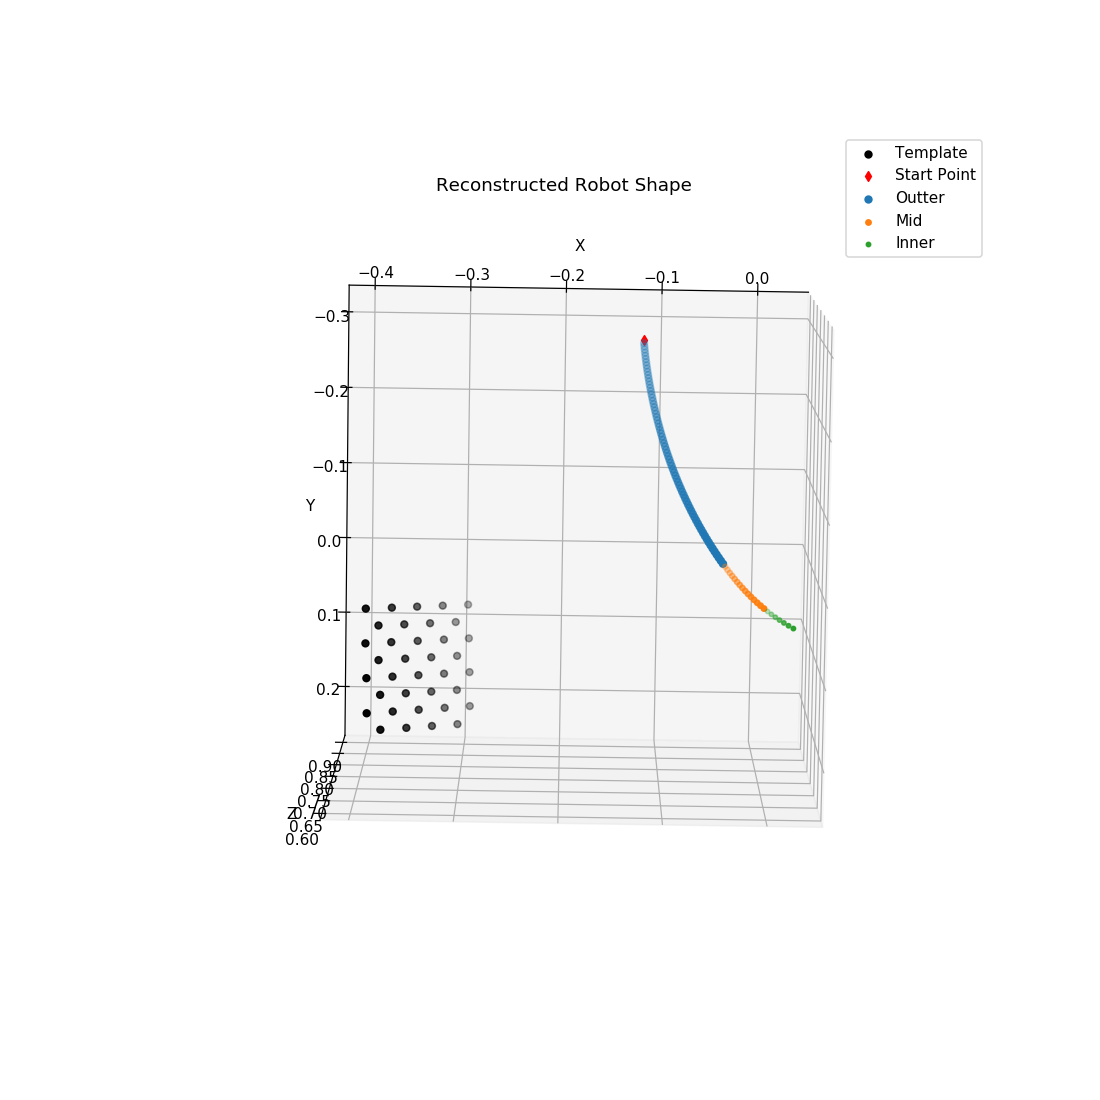

In [44]:
loc1 = np.array([[0],[0],[0]])
loc2 = np.matmul(R2, loc1 + T2)


%matplotlib notebook
idx = 400
pts3D = pts3D_eval[idx][2]
s1, s2 = pt_joint_eval[idx]

temp = cv2.triangulatePoints(PL_cal, PR_cal, imgl_pts, imgr_pts).T
temp3D = cv2.convertPointsFromHomogeneous(temp).T[:,0]

# Plot
Xs = pts3D[0]
Ys = pts3D[1]
Zs = pts3D[2]

Xs_tp = temp3D[0]
Ys_tp = temp3D[1]
Zs_tp = temp3D[2]

#%matplotlib inline
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')

#ax.scatter(Xs, Ys, Zs)
ax.scatter(Xs_tp, Ys_tp, Zs_tp, c = 'black', label = 'Template')

start = 0
jt1 = s1
jt2 = s2
end = len(pts3D[0])-1


ax.scatter(Xs[start], Ys[start], Zs[start], c='red', s=20, marker = 'd', label = 'Start Point')
# Outter Layer
ax.scatter(Xs[start+1:jt1], Ys[start+1:jt1], Zs[start+1:jt1], c='C0', s=20, label='Outter')
# Middle Layer
ax.scatter(Xs[jt1:jt2], Ys[jt1:jt2], Zs[jt1:jt2], c='C1', s=12, label='Mid')
#ax.scatter(Xs_tp[idx], Ys_tp[idx], Zs_tp[idx], c='blue', marker='x')
# Inner Layer
ax.scatter(Xs[jt2:end], Ys[jt2:end], Zs[jt2:end], c='C2', s=8, label='Inner')

#ax.scatter(loc1[0],loc1[1], loc1[2], c = 'blue')
#ax.scatter(loc2[0],loc2[1], loc2[2], c = 'red')

ax.legend()
#ax.scatter(loc1[0], loc1[1], loc1[2],c='red', marker='x')
#ax.scatter(loc2[0], loc2[1], loc2[2],c='blue', marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Reconstructed Robot Shape')
plt.show()

In [25]:
def distCal(pts):
    L = 0
    Xs, Ys, Zs = pts[0], pts[1], pts[2]
    for idx in range(len(pts)-1):
        xd = (Xs[idx-1]-Xs[idx])**2
        yd = (Ys[idx-1]-Ys[idx])**2
        zd = (Zs[idx-1]-Zs[idx])**2
        L += np.sqrt(xd+yd+zd)
    return L

In [45]:
# Recover scale from template points
Xs_tp = temp3D[0]
Ys_tp = temp3D[1]
Zs_tp = temp3D[2]

dist_dot = []
for idx in range(len(Xs_tp)-1):
    xd = (Xs_tp[idx]-Xs_tp[idx+1])**2
    yd = (Ys_tp[idx]-Ys_tp[idx+1])**2
    zd = (Zs_tp[idx]-Zs_tp[idx+1])**2
    L = np.sqrt(xd+yd+zd)
    if L < 0.1:
        dist_dot.append(L)
recon_dist = np.mean(dist_dot)

In [46]:
# Calcualte length from reconstruction results
dist_eval = {}
template_dist = 18.2
scale = template_dist/recon_dist
for idx in eval_idx:
    # Load reconstruction result
    pts3D = pts3D_eval[idx][2]
    # Load segment point idx
    seg_idx1 = pt_joint_eval[idx][0]
    seg_idx2 = pt_joint_eval[idx][1]
    # Outter seg
    seg1 = pts3D.T[0:seg_idx1]
    # Mid seg
    seg2 = pts3D.T[0:seg_idx2]
    # Inner seg
    seg3 = pts3D.T
    
    dist_out = distCal(seg1.T)*scale
    dist_mid = distCal(seg2.T)*scale
    dist_inner = distCal(seg3.T)*scale
    
    dist_eval[idx] = (dist_inner, dist_mid, dist_out) 

In [63]:
# Load length data
from scipy.io import loadmat
dist_gt = {}
for idx in eval_idx:
    mat = loadmat('../data/CTR_Robot/Robot_data/pos_' + str(idx) + '.mat')['pos'][0]
    # Calculate ground truth length
    dist_inner = 431 + mat[0]*1000
    dist_mid = 332 + mat[1]*1000
    dist_out = 174 + mat[2]*1000
    # Save results
    dist_gt[idx] = (dist_inner, dist_mid, dist_out)

In [71]:
# Caculate Error
error = {}
for idx in eval_idx:
    gt_in, gt_mid, gt_out = dist_gt[idx]
    cal_in, cal_mid, cal_out = dist_eval[idx]
    error[idx] = (gt_in-cal_in, gt_mid-cal_mid, gt_out-cal_out)

In [37]:
# Filter results from Segmentation Error
filt_idx = [416, 418, 437, 438, 448, 473, 335]
for key in filt_idx:
    if key in dist_eval:
        del dist_eval[key]
    if key in dist_gt:
        del dist_gt[key]
    if key in error:
        del error[key]
    if key in pts3D_eval:
        del pts3D_eval[key]
    if key in pt_seg_left:
        del pt_seg_left[key]
    if key in pt_seg_right:
        del pt_seg_right[key]

In [43]:
# Save Data
#np.save('pts3D_res.npy', pts3D_eval)
#np.save('dist_eval.npy', dist_eval)
#np.save('dist_gt.npy', dist_gt)
#np.save('dist_error.npy', error)
#np.save('./segmentation/evaluation_pt_left.npy', pt_seg_left)
#np.save('./segmentation/evaluation_pt_right_comp.npy', pt_seg_right)

## Result Analysis

In [15]:
pts3D_eval = np.load('./data/pts3D_res.npy').item()
dist_eval = np.load('./data/dist_eval.npy').item()
dist_gt = np.load('./data/dist_gt.npy').item()
error = np.load('./data/dist_error.npy').item()

out_cal = []
mid_cal = []
inner_cal = []

out_gt = []
mid_gt = []
inner_gt = []

out_error = []
mid_error = []
inner_error = []

index = []

for key in dist_eval.keys():
    index.append(key)
    
    out_cal.append(dist_eval[key][2])
    mid_cal.append(dist_eval[key][1])
    inner_cal.append(dist_eval[key][0])
    
    out_gt.append(dist_gt[key][2])
    mid_gt.append(dist_gt[key][1])
    inner_gt.append(dist_gt[key][0])
    
    out_error.append(error[key][2])
    mid_error.append(error[key][1])
    inner_error.append(error[key][0])

data = {
    'index': index,   
    'inner_cal': inner_cal,
    'mid_cal': mid_cal,
    'out_cal': out_cal,  
    'inner_gt':inner_gt,  
    'mid_gt': mid_gt,
    'out_gt': out_gt,
    'inner_error':inner_error,  
    'mid_error':mid_error,
    'out_error':out_error,
}

In [33]:
res_data = pd.DataFrame(data)
res_data

,index,inner_cal,mid_cal,out_cal,inner_gt,mid_gt,out_gt,inner_error,mid_error,out_error
0,302,188.333073,163.962505,128.754269,186.977156,191.964762,132.591364,-1.355917,28.002256,3.837096
1,303,179.837499,135.840738,121.669485,178.156177,158.868869,125.600418,-1.681322,23.028131,3.930933
2,304,156.751443,131.472006,112.406965,146.941100,155.127312,112.961691,-9.810343,23.655307,0.554725
3,305,188.446337,154.026954,113.234518,193.805948,178.092998,115.864642,5.359610,24.066043,2.630125
4,307,174.295335,147.676457,102.940787,172.531569,174.889059,106.525681,-1.763766,27.212602,3.584894
5,309,166.294648,147.128366,116.569852,160.487379,172.324057,119.157818,-5.807269,25.195691,2.587965
6,311,201.675483,155.176596,149.370246,198.869247,180.410606,153.740611,-2.806236,25.234011,4.370365
7,312,210.874604,191.094537,154.938819,209.687883,222.435219,158.718207,-1.186721,31.340682,3.779388
8,315,188.949011,144.900668,113.110746,188.528111,171.622412,117.943901,-0.420900,26.721744,4.833155
9,317,173.598906,127.933341,119.368410,172.808661,152.529149,125.125789,-0.790245,24.595809,5.757379


### Correlation between Reconstruction and Ground Truth

In [5]:
res_data['inner_cal']
np.corrcoef(res_data['inner_cal'], res_data['inner_gt'])

array([[1.        , 0.94738242],
       [0.94738242, 1.        ]])

In [6]:
np.corrcoef(res_data['mid_cal'], res_data['mid_gt'])

array([[1.        , 0.99764552],
       [0.99764552, 1.        ]])

In [7]:
np.corrcoef(res_data['out_cal'], res_data['out_gt'])

array([[1.        , 0.99867415],
       [0.99867415, 1.        ]])

It is clear to see strong positive linear correlation between reconstruction results and ground truth length. 

### Mean and variance of absolute length error

In [8]:
mean = np.mean(np.abs(res_data['inner_error']))
var = np.var(np.abs(res_data['inner_error']))
print('Inner tube: Mean %f, Variance %f' % (mean, var))

Inner tube: Mean 5.548291, Variance 40.837483


In [9]:
mean = np.mean(np.abs(res_data['mid_error']))
var = np.var(np.abs(res_data['mid_error']))
print('Middle tube: Mean %f, Variance %f' % (mean, var))

Middle tube: Mean 25.641476, Variance 3.760363


In [10]:
mean = np.mean(np.abs(res_data['out_error']))
max_d = np.max(np.abs(res_data['out_error']))
min_d = np.min(np.abs(res_data['out_error']))
var = np.var(np.abs(res_data['out_error']))
print('Outter tube: Max: %f, Min %f, Mean %f, Variance %f' % (max_d, min_d, mean, var))

Outter tube: Max: 6.591972, Min 0.261806, Mean 2.888948, Variance 2.285133


In [11]:
percent_error = np.divide(np.abs(res_data['out_error']), res_data['out_gt'])
mean = np.mean(percent_error)
max_p = np.max(percent_error)
print('Outter tube error percentage: Mean: %f, Max: %f' % (mean, max_p))

Outter tube error percentage: Mean: 0.024305, Max: 0.046013


### Result Plotting

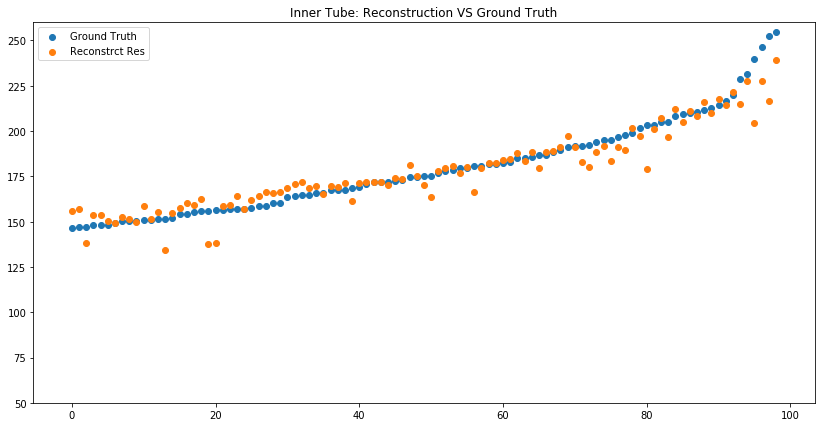

In [12]:
%matplotlib inline
x = range(0,len(res_data['inner_cal']))
sort_by_innerCal = res_data.sort_values(['inner_gt'])
plt.figure(figsize=(14, 7))
plt.scatter(x, sort_by_innerCal['inner_gt'], label = 'Ground Truth')
plt.scatter(x, sort_by_innerCal['inner_cal'], label = 'Reconstrct Res')
plt.ylim([50, 260])
plt.legend()
plt.title('Inner Tube: Reconstruction VS Ground Truth')
plt.show()

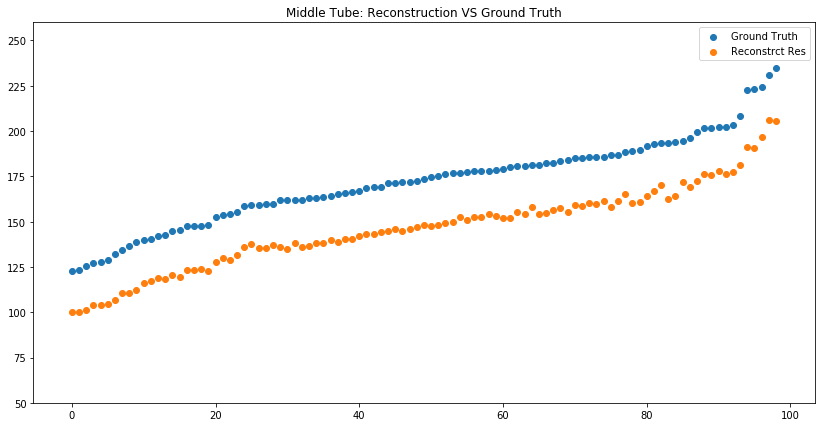

In [13]:
x = range(0,len(res_data['mid_cal']))
sort_by_midCal = res_data.sort_values(['mid_gt'])
plt.figure(figsize=(14, 7))
plt.scatter(x, sort_by_midCal['mid_gt'], label = 'Ground Truth')
plt.scatter(x, sort_by_midCal['mid_cal'], label = 'Reconstrct Res')
plt.ylim([50, 260])
plt.legend()
plt.title('Middle Tube: Reconstruction VS Ground Truth')
plt.show()

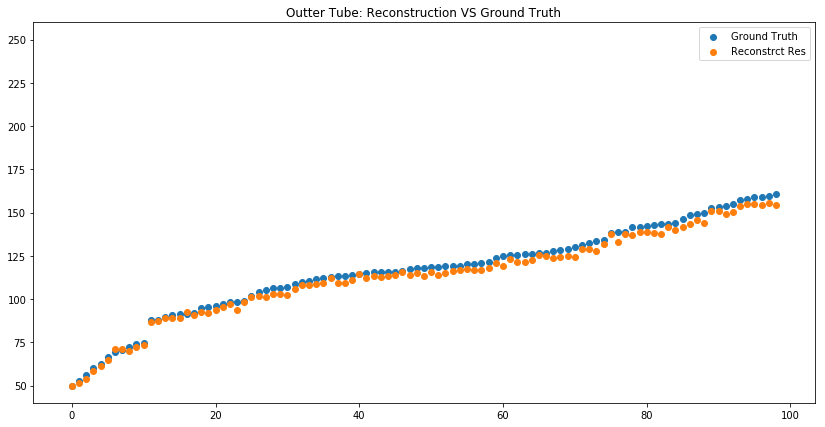

In [16]:
x = range(0,len(res_data['out_cal']))
sort_by_outCal = res_data.sort_values(['out_gt'])
plt.figure(figsize=(14, 7))
plt.scatter(x, sort_by_outCal['out_gt'], label = 'Ground Truth')
plt.scatter(x, sort_by_outCal['out_cal'], label = 'Reconstrct Res')
plt.ylim([40, 260])
plt.legend()
plt.title('Outter Tube: Reconstruction VS Ground Truth')
plt.show()

In [34]:
from scipy.io import loadmat
loadmat('../data/CTR_Robot/Robot_data/pos_350.mat')['pos'][0]

array([-0.26206554, -0.14221523, -0.05372378,  1.199478  ,  0.77597862,
        0.8283165 ])

In [36]:
431 - 262

169

In [35]:
332 - 142

190